In [1]:
import nltk
nltk.download('reuters')  # Download the Reuters corpus
nltk.download('punkt')

from nltk.corpus import reuters
import re
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import tkinter as tk
from tkinter import Label, Entry, Button, Text, Scrollbar

[nltk_data] Downloading package reuters to /Users/harshit/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /Users/harshit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Access the text data
corpus = reuters.raw()

In [3]:
class NGramLanguageModel:
    """
    Class for creating an n-gram language model.
    """
    def __init__(self, corpus, n=2):
        """
        Initialize the n-gram language model.
        
        Parameters:
        - corpus (str): The text corpus to be used for training the model.
        - n (int): The size of the n-grams.
        """
        self.corpus = corpus
        self.n = n
        self.clean_corpus = self.preprocess_text()
        self.tokenized_text = word_tokenize(self.clean_corpus)
        self.vocab_size = len(set(self.tokenized_text))
        self.ngrams = self.create_ngrams(self.tokenized_text)
        self.ngram_freq = self.cal_ngram_freq(self.ngrams)

    def preprocess_text(self):
        """
        Clean and preprocess the given text.

        Returns:
        str: The preprocessed text.
        """ 
        # remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', self.corpus)
        # convert to lowercase
        text = text.lower() 
        return text

    def create_ngrams(self, tokens):
        """
        Create n-grams from a list of tokens.

        Parameters:
        - tokens (list): List of tokens.

        Returns:
        list: List of n-grams.
        """
        ngrams = []
        # iterate over the range of indices to create n-grams
        for i in range(len(tokens) - self.n + 1):
            # extract a tuple of n tokens from the current position
            ngram = tuple(tokens[i:i + self.n])
            # append the n-gram to the list
            ngrams.append(ngram)
        return ngrams

    def cal_ngram_freq(self, ngrams):
        """
        Calculate the frequency of each n-gram in the dataset.

        Parameters:
        - ngrams (list): List of n-grams.

        Returns:
        Counter: A Counter object containing the frequencies of each n-gram.
        """
        return Counter(ngrams)

    def calculate_probability(self, word, last_ngram):
        """
        Calculate the probability of a word following a given (n-1)-gram using Laplace smoothing.

        Parameters:
        - word (str): The word for which the probability is calculated.
        - last_ngram (tuple): The (n-1)-gram preceding the word.

        Returns:
        float: The probability of the word following the given (n-1)-gram.
        """
        # with laplace smoothing
        numeratorProb = self.ngram_freq[last_ngram + (word,)] + 1
        denominatorProb = self.ngram_freq[last_ngram] + self.vocab_size
        return numeratorProb / denominatorProb

    def predict_next_word(self, last_ngram):
        """
        Predict the next word given a sequence of words based on n-gram probabilities.

        Parameters:
        - last_ngram (tuple): The (n-1)-gram preceding the next word.
        - ngram_freq (Counter): Frequencies of n-grams in the dataset.

        Returns:
        str: The predicted next word.
        """
        next_word_counts = defaultdict(int)
        # First, check if the first (n-1) elements of the current n-gram match the provided (n-1)-gram
        # then, create a set from the list of next words
        for ngram in self.ngram_freq:
            if ngram[:-1] == last_ngram:
                next_word_counts[ngram[-1]] += self.ngram_freq[ngram]
        next_word_counts = set([ngram[-1] for ngram in self.ngram_freq if ngram[:-1] == last_ngram])
        # If there are no possible next words, return a default value (e.g., "<UNKNOWN>")
        if not next_word_counts:
            return "<UNKNOWN>"
        probabilities = {word: self.calculate_probability(word, last_ngram) for word in next_word_counts}
        # return word with highest probability
        most_common_word = max(probabilities, key=probabilities.get)
        return most_common_word
    

    def generate_sentence(self, prefix, length):
        """
        Generate a sentence of a specified length given a prefix of (n-1) words.

        Parameters:
        - prefix (list): The prefix of the sentence.
        - length (int): The length of the generated sentence.

        Working:
        Suppose prefix = ['the', 'quick'], and the length of the generated sentence is 3. 
        The function will start with the prefix and iteratively predict the next word to extend the sentence.
        It will generate the following sequence of (n-1)-grams:
        Iteration 1: prev_ngram = tuple(['the', 'quick'])
        Iteration 2: prev_ngram = tuple(['quick', 'predicted_word1'])
        Iteration 3: prev_ngram = tuple(['predicted_word1', 'predicted_word2'])

        Returns:
        str: The generated sentence.
        """
        generated_sentence = prefix.copy()
        # generate the next word until the sentence reaches the desired length
        while len(generated_sentence) < length + len(prefix):
            # get the last (n-1) words of the generated sentence
            prev_ngram = tuple(generated_sentence[-self.n + 1:])
            # predict the next word
            predicted_word = self.predict_next_word(prev_ngram)
            # append the predicted word to the generated sentence
            generated_sentence.append(predicted_word)
        return ' '.join(generated_sentence[len(prefix):])

    
    def get_ngrams(self):
        """
        Get the n-grams in the dataset.

        Returns:
        list: List of n-grams.
        """
        return self.ngrams

    def get_ngram_freq(self):
        """
        Get the frequencies of n-grams in the dataset.

        Returns:
        Counter: A Counter object containing the frequencies of each n-gram.
        """
        return self.ngram_freq

In [4]:
bigram_model = NGramLanguageModel(corpus, n=2)
bigrams = bigram_model.get_ngrams()
bigrams[:10]

[('asian', 'exporters'),
 ('exporters', 'fear'),
 ('fear', 'damage'),
 ('damage', 'from'),
 ('from', 'usjapan'),
 ('usjapan', 'rift'),
 ('rift', 'mounting'),
 ('mounting', 'trade'),
 ('trade', 'friction'),
 ('friction', 'between')]

In [5]:
trigram_model = NGramLanguageModel(corpus, n=3)
trigrams = trigram_model.get_ngrams()
trigrams[:10]

[('asian', 'exporters', 'fear'),
 ('exporters', 'fear', 'damage'),
 ('fear', 'damage', 'from'),
 ('damage', 'from', 'usjapan'),
 ('from', 'usjapan', 'rift'),
 ('usjapan', 'rift', 'mounting'),
 ('rift', 'mounting', 'trade'),
 ('mounting', 'trade', 'friction'),
 ('trade', 'friction', 'between'),
 ('friction', 'between', 'the')]

In [6]:
# Example for bigram frequencies
bigram_frequencies = bigram_model.get_ngram_freq()
# Print the 10 most common bigrams
bigram_frequencies.most_common(10)

[(('in', 'the'), 7091),
 (('of', 'the'), 6908),
 (('said', 'the'), 5353),
 (('mln', 'dlrs'), 4400),
 (('said', 'it'), 4343),
 (('vs', 'mln'), 3945),
 (('mln', 'vs'), 3921),
 (('cts', 'vs'), 3311),
 (('for', 'the'), 2806),
 (('the', 'company'), 2607)]

/Users/harshit/anaconda3/envs/ds5983env/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


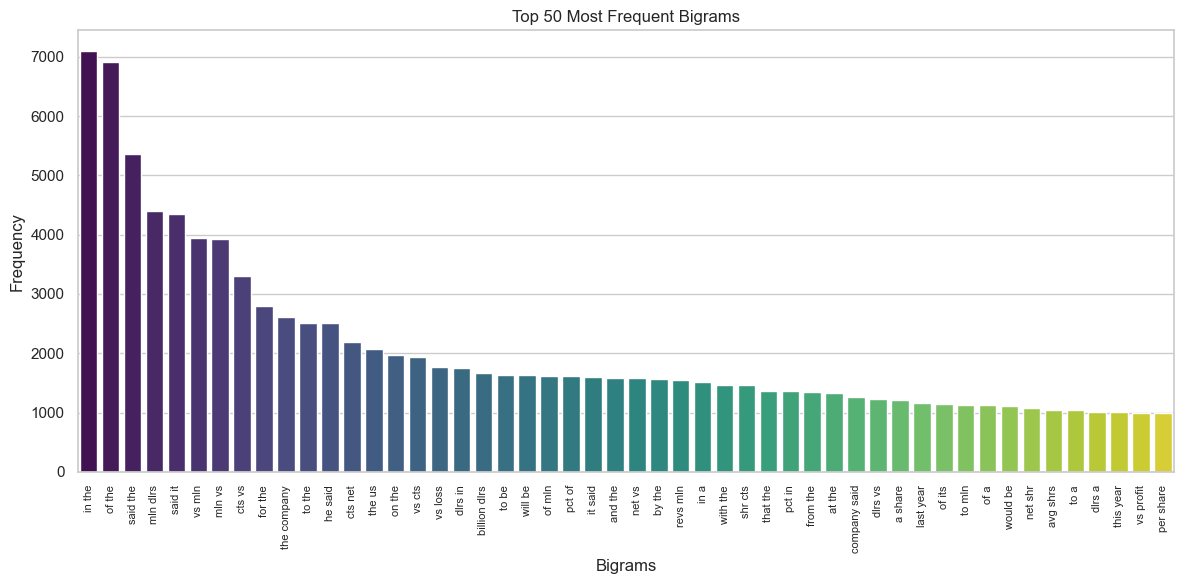

In [7]:
# Get the top 50 most frequent bigrams
top_50_bigrams = dict(bigram_frequencies.most_common(50))

# Extract bigram labels and frequencies
bigram_labels = [' '.join(bigram) for bigram in top_50_bigrams.keys()]
bigram_counts = list(top_50_bigrams.values())

# Set Seaborn style
sns.set(style="whitegrid")

# Plotting with Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=bigram_labels, y=bigram_counts, palette="viridis")
ax.set(xlabel='Bigrams', ylabel='Frequency')
ax.set_title('Top 50 Most Frequent Bigrams')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.tight_layout()
plt.show()


/Users/harshit/anaconda3/envs/ds5983env/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


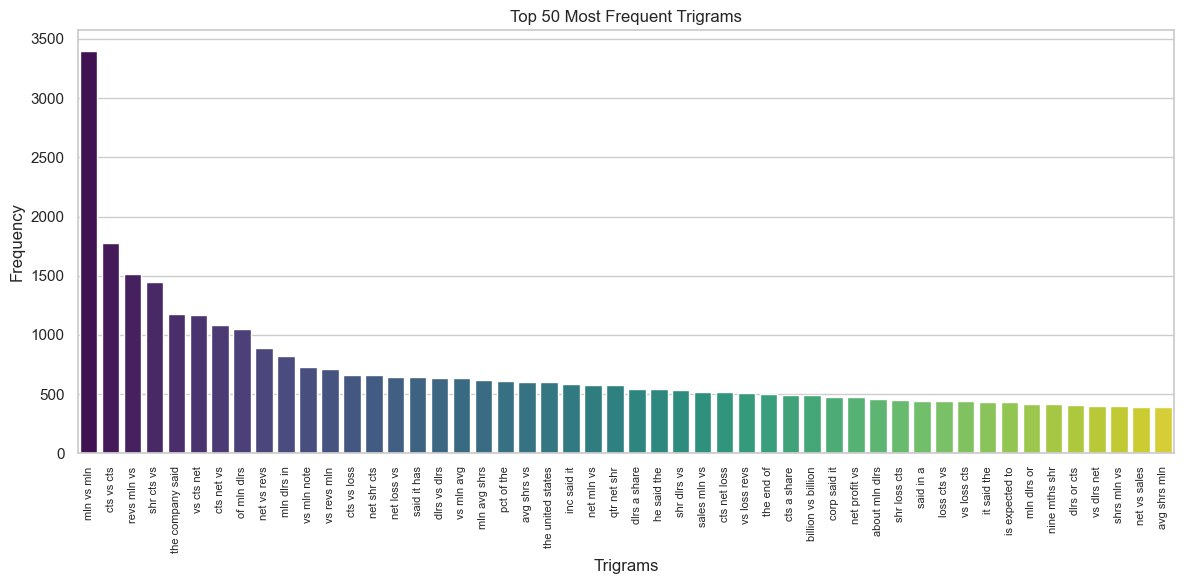

In [8]:
trigram_frequencies = trigram_model.get_ngram_freq()
# Get the top 50 most frequent trigrams 
top_50_trigrams = dict(trigram_frequencies.most_common(50))

# Extract bigram labels and frequencies
trigram_labels = [' '.join(trigram) for trigram in top_50_trigrams.keys()]
trigram_counts = list(top_50_trigrams.values())

# Set Seaborn style
sns.set(style="whitegrid")

# Plotting with Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=trigram_labels, y=trigram_counts, palette="viridis")
ax.set(xlabel='Trigrams', ylabel='Frequency')
ax.set_title('Top 50 Most Frequent Trigrams')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.tight_layout()
plt.show()


In [9]:
print(bigram_model.predict_next_word(('the',)))
print(bigram_model.predict_next_word(('of',)))
print(bigram_model.predict_next_word(('blue',)))
print(bigram_model.predict_next_word(('their',)))
print(bigram_model.predict_next_word(('time',)))

company
the
arrow
own
of


In [19]:
# Choose a prefix for testing
test_prefix = ['for', 'the', 'man', 'he', 'is']

# Test the model with different (n-1)-grams
for i in range(1, len(test_prefix)+1):
    current_prefix = test_prefix[:i]
    generated_sentence = NGramLanguageModel(corpus, 2).generate_sentence(current_prefix, 5)
    print(f"Generated sentence with prefix {current_prefix}: {generated_sentence}")


Generated sentence with prefix ['for']: the company said the company
Generated sentence with prefix ['for', 'the']: company said the company said
Generated sentence with prefix ['for', 'the', 'man']: said the company said the
Generated sentence with prefix ['for', 'the', 'man', 'he']: said the company said the
Generated sentence with prefix ['for', 'the', 'man', 'he', 'is']: expected to the company said


In [21]:
# Choose a prefix for testing
test_prefix = ['for', 'the', 'man', 'he', 'is']

# Test the model with different (n-1)-grams
for i in range(1, len(test_prefix)+1):
    current_prefix = test_prefix[:i]
    generated_sentence = NGramLanguageModel(corpus, 3).generate_sentence(current_prefix, 5)
    print(f"Generated sentence with prefix {current_prefix}: {generated_sentence}")

Generated sentence with prefix ['for']: <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN>
Generated sentence with prefix ['for', 'the']: year ended march the company
Generated sentence with prefix ['for', 'the', 'man']: workforce of rank xerox south
Generated sentence with prefix ['for', 'the', 'man', 'he']: <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN>
Generated sentence with prefix ['for', 'the', 'man', 'he', 'is']: not a threat to the


In [11]:
print(bigram_model.generate_sentence(['the', 'use'], 10))
print(bigram_model.generate_sentence(['he', 'said'], 10))
print(trigram_model.generate_sentence(['for', 'the', 'company'], 10))
print(trigram_model.generate_sentence(['the', 'united', 'states'], 10))

of the company said the company said the company said
the company said the company said the company said the
said the company said the company said the company said
and japan to open its markets to us goods the


In [12]:
corpus[2000:2500]

'to allow imports of U.S. Products, if we\n  want to defuse problems from possible U.S. Retaliation," said\n  Paul Sheen, chairman of textile exporters &lt;Taiwan Safe Group>.\n      A senior official of South Korea\'s trade promotion\n  association said the trade dispute between the U.S. And Japan\n  might also lead to pressure on South Korea, whose chief exports\n  are similar to those of Japan.\n      Last year South Korea had a trade surplus of 7.1 billion\n  dlrs with the U.S., Up from 4.9 billion dl'

In [13]:
print(NGramLanguageModel(corpus, 4).generate_sentence(['the', 'united', 'states', 'of'], 10))
print(NGramLanguageModel(corpus, 4).generate_sentence(['a', 'trade', 'of', 'the'], 10))
print(NGramLanguageModel(corpus, 4).generate_sentence(['he', 'said', 'that', 'his'], 10))
print(NGramLanguageModel(corpus, 4).generate_sentence(['what', 'do', 'you', 'think'], 10))
print(NGramLanguageModel(corpus, 4).generate_sentence(['is', 'this', 'what', 'you'], 10))

textiles and apparel and electronic goods as well as the
dutch animal grain and feed association tom vongarlem assistant deputy
country the worlds biggest institutional investor analysts said the budget
<UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN>
<UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN>


In [14]:
print(NGramLanguageModel(corpus, 5).generate_sentence(['the', 'united', 'states', 'of', 'america'], 10))
print(NGramLanguageModel(corpus, 5).generate_sentence(['a', 'trade', 'of', 'the', 'wealth'], 10))
print(NGramLanguageModel(corpus, 5).generate_sentence(['he', 'said', 'that', 'his'], 10))
print(NGramLanguageModel(corpus, 5).generate_sentence(['of', 'the', 'company', 'of'], 10))
print(NGramLanguageModel(corpus, 5).generate_sentence(['is', 'this', 'what', 'you'], 10))

<UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN>
<UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN>
<UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN>
<UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN>
<UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN>


In [15]:
class NgramPredictorUI:
    def __init__(self, main):
        self.main = main
        self.main.title("N-gram Predictor")

        # GUI components
        self.n_label = Label(main, text="Enter value of 'n':")
        self.n_entry = Entry(main)
        self.prefix_label = Label(main, text="Enter Prefix:")
        self.prefix_entry = Entry(main)
        self.len_label = Label(main, text="Desired Sentence Length:")
        self.len_entry = Entry(main)
        self.predict_button = Button(main, text="Predict", command=self.predict_sentence)
        self.result = Text(main, height=10, width=50, wrap="word")
        self.scrollbar = Scrollbar(main, command=self.result.yview)

        # Place components
        self.n_label.grid(row=0, column=0, padx=10, pady=5)
        self.n_entry.grid(row=0, column=1, padx=10, pady=5)
        self.prefix_label.grid(row=1, column=0, padx=10, pady=5)
        self.prefix_entry.grid(row=1, column=1, padx=10, pady=5)
        self.len_label.grid(row=2, column=0, padx=10, pady=5)
        self.len_entry.grid(row=2, column=1, padx=10, pady=5)
        self.predict_button.grid(row=3, column=0, columnspan=2, pady=10)
        self.result.grid(row=4, column=0, columnspan=2, padx=10, pady=5)
        self.scrollbar.grid(row=4, column=2, sticky="ns")

        # Configure scrollbar
        self.result.config(yscrollcommand=self.scrollbar.set)

    def predict_sentence(self):
        n = int(self.n_entry.get())
        prefix = self.prefix_entry.get().split()
        length = int(self.len_entry.get())
        
        if len(prefix) < n:
            self.result.delete(1.0, tk.END)
            self.result.insert(tk.END, "Error: Prefix should contain at least (n-1) words.")
            return

        generated_sentence = NGramLanguageModel(corpus, n).generate_sentence(prefix, length)
        self.result.delete(1.0, tk.END)
        self.result.insert(tk.END, generated_sentence)



In [16]:
root = tk.Tk()

app = NgramPredictorUI(root)
root.mainloop()